# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

class Actor(nn.Module):
    def __init__(self, state_size, action_size, fc1=512, fc2=256, leak=0.01, seed=0):
        """ Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            hidden_size (int): Number of nodes in hidden layers
            leak: amount of leakiness in leaky relu
        """
        super(Actor, self).__init__()
        self.leak = leak
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, fc1)
        self.fc2 = nn.Linear(fc1, fc2)
        self.fc3 = nn.Linear(fc2, 128)
        self.fc4 = nn.Linear(128, action_size)

        self.bn = nn.BatchNorm1d(state_size)
        self.reset_parameters()

    def reset_parameters(self):
        """ Initilaize the weights using He et al (2015) weights """
        torch.nn.init.kaiming_normal_(self.fc1.weight.data, a=self.leak, mode='fan_in')
        torch.nn.init.kaiming_normal_(self.fc2.weight.data, a=self.leak, mode='fan_in')
        torch.nn.init.kaiming_normal_(self.fc3.weight.data, a=self.leak, mode='fan_in')
        torch.nn.init.uniform_(self.fc4.weight.data, -3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        state = self.bn(state)
        x = F.leaky_relu(self.fc1(state), negative_slope=self.leak)
        x = F.leaky_relu(self.fc2(x), negative_slope=self.leak)
        x = F.leaky_relu(self.fc3(x), negative_slope=self.leak)
        x =  torch.tanh(self.fc4(x))
        return x


class Critic(nn.Module):
    def __init__(self, state_size, action_size, fc1=512, fc2=256, fc3=128, leak=0.01, seed=0):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
            hidden_size:
        """
        super(Critic, self).__init__()
        self.leak = leak
        self.seed = torch.manual_seed(seed)
        self.bn = nn.BatchNorm1d(state_size)
        self.fcs1 = nn.Linear(state_size, fc1)
        self.fc2 = nn.Linear(fc1 + action_size, fc2)
        self.fc3 = nn.Linear(fc2, fc3)
        self.fc4 = nn.Linear(fc3, 1)
        self.reset_parameters()

    def reset_parameters(self):
        """ Initilaize the weights using He et al (2015) weights """
        torch.nn.init.kaiming_normal_(self.fcs1.weight.data, a=self.leak, mode='fan_in')
        torch.nn.init.kaiming_normal_(self.fc2.weight.data, a=self.leak, mode='fan_in')
        torch.nn.init.uniform_(self.fc3.weight.data, -3e-3, 3e-3)

    def forward(self, state, action):
        """ Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        state = self.bn(state)
        x = F.leaky_relu(self.fcs1(state), negative_slope=self.leak)
        x = torch.cat((x, action), dim=1)
        x = F.leaky_relu(self.fc2(x), negative_slope=self.leak)
        x = F.leaky_relu(self.fc3(x), negative_slope=self.leak)
        x =  self.fc4(x)
        return x

In [5]:
import numpy as np
import copy
from collections import namedtuple, deque
import random

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 800       # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 3e-4        # learning rate of the critic
WEIGHT_DECAY = 0.0001   # L2 weight decay
LEAKINESS = 0.01

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():
    def __init__(self, state_size, action_size, n_agents=1, seed=0):
        """Initialize an Agent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            n_agents: number of agents it will control in the environment
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = np.random.seed(seed)
        random.seed(seed)
        self.n_agents = n_agents

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, leak=LEAKINESS, seed=seed).to(device)
        self.actor_target = Actor(state_size, action_size, leak=LEAKINESS, seed=seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, leak=LEAKINESS, seed=seed).to(device)
        self.critic_target = Critic(state_size, action_size, leak=LEAKINESS, seed=seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC)
        # self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.timesteps = 0  

    def step(self, states, actions, rewards, next_states, dones):
        """ Given a batch of S,A,R,S' experiences, it saves them into the
            experience buffer, and occasionally samples from the experience
            buffer to perform training steps.
        """
        self.timesteps += 1
        for i in range(self.n_agents):
            self.memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i])

        if (len(self.memory) > BATCH_SIZE) and (self.timesteps % 20 == 0):
            for _ in range(10):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, states, add_noise=True):
        """ Given a list of states for each agent it returns the actions to be
            taken by each agent based on the current policy.
            Returns a numpy array of shape [n_agents, n_actions]
            NOTE: clips actions to be between -1, 1
        Args:
            states:    () one row of state for each agent [n_agents, n_actions]
            add_noise: (bool) add noise to the actions?
        """
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            actions += [self.noise.sample() for _ in range(self.n_agents)]
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    @property
    def device(self):
        return device

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = np.random.seed(seed)
        random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([np.random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = np.random.seed(seed)
        random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [6]:


# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])



Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [7]:


seed = 66

# Create agent
agent = Agent(state_size=state_size, action_size=action_size, n_agents=num_agents, seed=seed)



In [8]:
def ddpg(n_episodes=2000, max_t = 1500, window_size=100, score_threshold=30.0, 
         print_interval=10, epochs=1000):

    scores_deque = deque(maxlen=window_size) 
    scores = []        
    best_average_score = -np.inf
    print("Training on {} started...".format(agent.device))
    
    for i_episode in range(1, epochs+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        agent.reset()
        episode_scores = np.zeros(num_agents) 

        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agent.step(states=states, actions=actions, rewards=rewards, next_states=next_states, dones=dones)
            episode_scores += np.array(rewards)
            states = next_states
            if np.any(dones):
                break

        episode_score = np.mean(episode_scores) # Summary of scores for this episode
        scores_deque.append(episode_score)
        scores.append(episode_score)
        average_score = np.mean(scores_deque)

        print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score), end="")
        if i_episode % print_interval == 0:
            print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actortmp.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critictmp.pth')
        if average_score >= score_threshold:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode-window_size, average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

    np.save('score.npy', scores)
    return scores

In [ ]:
scores = ddpg()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Training on cuda:0 started...
Episode: 10	Average Score: 0.49	Current Score: 0.70
Episode: 20	Average Score: 0.64	Current Score: 1.04
Episode: 30	Average Score: 0.97	Current Score: 2.48
Episode: 40	Average Score: 1.58	Current Score: 4.02
Episode: 50	Average Score: 2.52	Current Score: 8.21
Episode: 60	Average Score: 3.73	Current Score: 13.12
Episode: 70	Average Score: 4.98	Current Score: 13.11
Episode: 80	Average Score: 6.45	Current Score: 18.45
Episode: 90	Average Score: 7.82	Current Score: 19.16
Episode: 100	Average Score: 9.06	Current Score: 20.11
Episode: 101	Average Score: 9.24	Current Score: 18.04

In [10]:
#resum training  in casw connection failer
# reset the bnnnjmnm      




agent.actor_local.load_state_dict(torch.load('checkpoint_actortmp.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critictmp.pth'))

def ddpg(n_episodes=2000, max_t = 1500, window_size=100, score_threshold=31.0, 
         print_interval=10, epochs=1000):

    scores_deque = deque(maxlen=window_size) 
    scores = []        
    best_average_score = -np.inf
    print("Training on {} started...".format(agent.device))
    
    for i_episode in range(1, epochs+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        agent.reset()
        episode_scores = np.zeros(num_agents) 

        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agent.step(states=states, actions=actions, rewards=rewards, next_states=next_states, dones=dones)
            episode_scores += np.array(rewards)
            states = next_states
            if np.any(dones):
                break

        episode_score = np.mean(episode_scores) # Summary of scores for this episode
        scores_deque.append(episode_score)
        scores.append(episode_score)
        average_score = np.mean(scores_deque)

        print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score), end="")
        if i_episode % print_interval == 0:
            print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actortmp.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critictmp.pth')
            #torch.save(agent, 'fullagent_checkpoint.pth')
        if average_score >= score_threshold:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode-window_size, average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            #torch.save(agent, 'fullbestagent.pth')
            break

    np.save('score.npy', scores)
    return scores

In [11]:
scores = ddpg()


Training on cuda:0 started...
Episode: 10	Average Score: 0.31	Current Score: 0.52
Episode: 20	Average Score: 0.66	Current Score: 1.71
Episode: 30	Average Score: 1.66	Current Score: 4.83
Episode: 40	Average Score: 3.43	Current Score: 11.29
Episode: 50	Average Score: 5.72	Current Score: 20.08
Episode: 60	Average Score: 9.06	Current Score: 23.56
Episode: 70	Average Score: 11.29	Current Score: 22.47
Episode: 80	Average Score: 12.89	Current Score: 24.49
Episode: 90	Average Score: 14.43	Current Score: 28.57
Episode: 100	Average Score: 16.10	Current Score: 31.96
Episode: 110	Average Score: 19.32	Current Score: 32.05
Episode: 120	Average Score: 22.27	Current Score: 30.35
Episode: 130	Average Score: 25.17	Current Score: 34.06
Episode: 140	Average Score: 27.61	Current Score: 31.63
Episode: 150	Average Score: 29.44	Current Score: 33.04
Episode: 160	Average Score: 30.10	Current Score: 32.73
Episode: 170	Average Score: 30.63	Current Score: 26.20
Episode: 177	Average Score: 31.05	Current Score: 30.1

NameError: name 'plt' is not defined

In [12]:
import matplotlib.pyplot as plt


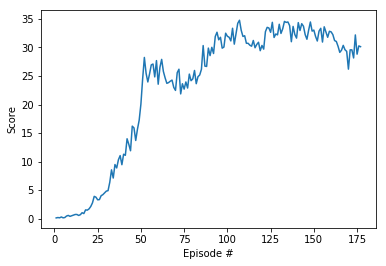

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()